In [1]:
import os
import sys
os.chdir('..')
sys.path.append(os.getcwd())

In [2]:
import torch
from Models.pretrain import *
from Models.cPB import cPB
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pickle
import argparse
from torch.autograd import Variable
import pprint
import copy
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='torch.storage')
warnings.filterwarnings("ignore", category=UserWarning, module='torch.storage')
warnings.filterwarnings("ignore", category=DeprecationWarning, module='torch.storage')

# SINE datasets


## CONFIGURATION:


## Executable code:


In [ ]:
hidden_size_list = [150]
pretrain_mask_list = ['4']
for hidden in hidden_size_list:
  for pretrain in pretrain_mask_list:
    for iter in range(1,11):
      base_model = 'GRU'
      batch_size = 128
      hidden_size = hidden
      seq_len = 10
      epoch_size=10
      lr = 0.01
      number_of_tasks=4
      mask_selection_NofBatch = 50
      input_size=2
      iteration=iter
      mask_init='uniform'
      dataset='SINE'
      dataset_name = "sine_rw10_mode5_extended_16-16_2341"
      Pretrain_task = pretrain
      df = pd.read_csv(os.path.join(f"datasets/{dataset}/", f"{dataset_name}.csv"))
      pretrain_model_addr=f'Performance/Pretrain/{base_model}/{dataset}/After/{dataset}-Task_{Pretrain_task}-{base_model}-pretrain-hidden{hidden_size}-epoch10_iter{iteration}.pickle'
      mask_weights=[] #if we have initial masks then reload it here


      mask_option = 'SUM'
      model_type = 'cPB'
      batch_first = True
      low_rank = False
      model=cPB(lr = lr ,hidden_size = hidden_size, seq_len = seq_len,base_model = base_model, pretrain_model_addr = pretrain_model_addr,
                mask_weights = mask_weights, mask_init = mask_init, number_of_tasks = number_of_tasks, epoch_size = epoch_size,
                input_size = input_size, mask_option = mask_option, model_type = model_type, batch_first = batch_first, low_rank = low_rank)


      # loop for each task
      for task in range(1, df["task"].max() + 1):
        df_task = df[df["task"] == task]
        df_task = df_task.drop(columns="task")
        # loop based on each batch of data
        batch_cont=0
        model.weights_copy(task)
        for i in range(0, len(df_task), batch_size):
          x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
          y = list(df_task.iloc[i : i + batch_size, -1])
          if batch_cont<mask_selection_NofBatch:
            for mask_index in range (0, task):
              model.predict_many(x,y,mask_index,task,mask_selection=True)
              model.learn_many(x,y,mask_index)
            batch_cont+=1
          elif batch_cont==mask_selection_NofBatch:
            best_mask_index=model.add_new_column(task)
            model.predict_many(x,y,best_mask_index,task,mask_selection=False)
            model.learn_many(x,y,best_mask_index)
            batch_cont+=1
          elif batch_cont>mask_selection_NofBatch:
            batch_cont+=1
            model.predict_many(x,y,best_mask_index,task,mask_selection=False)
            model.learn_many(x,y,best_mask_index)
        model.save_final_metrics(task,best_mask_index)
        model.final_weights_saving()
      model.plotting()


      file_path = f'Performance/Results/{model_type}/{dataset}/Periodic/pretrain-T{Pretrain_task}_{base_model}-{dataset_name}-hidden{hidden_size}-epoch10-Mask_{mask_option}_iter{iteration}.pkl'
      with open(file_path, 'wb') as file:
          pickle.dump(model.performance, file)

      file_path = f'Performance/Results/{model_type}/{dataset}/Periodic/pretrain-T{Pretrain_task}_{base_model}-{dataset_name}-hidden{hidden_size}-epoch10-Mask_{mask_option}_iter{iteration}_selectedMask.pkl'
      with open(file_path, 'wb') as file:
          pickle.dump(model.selected_mask_index, file)

      file_path=f'Performance/Final Models/{model_type}/{base_model}/{dataset}/Periodic/{dataset_name}-{base_model}-pretrain-hidden{hidden_size}-epoch10-Mask_{mask_option}-itter{iteration}.pickle'
      with open(file_path, 'wb') as file:
          pickle.dump(model.all_models_weight, file)

# Weather datasets


## CONFIGURATION:


In [6]:
# TODO
dataset='Weather'
dataset_name = "weather_pretraining"
batch_size = 128
hidden_size = 300
seq_len = 11
iterations = 10
output_size = 2
input_size = 4
num_layers = 1
loss_on_seq = False
freeze_inputs_weights = False
pretraining_samples = 0
pretraining_epochs = 0
write_weights = False
combination = False
model_type = 'GRU' # or LSTM
if model_type == "GRU":
    model_class = GRU_Model
elif model_type == "LSTM":
    model_class = LSTM_Model



df = pd.read_csv(f"datasets/{dataset}/{dataset_name}.csv")
df_task = df.drop('task', axis=1)



for itter in range(1,iterations+1):
  Model = model_class(input_size=input_size,
        device=torch.device("cpu"),
      	num_layers=num_layers,
        hidden_size=hidden_size,
        output_size=output_size,
        batch_size=batch_size,
          )


  if len(df_task) % batch_size == 0:
    n_batches = int(len(df_task) / batch_size)
  else:
    n_batches = int(len(df_task) / batch_size) + 1
  optimizer = torch.optim.Adam(Model.parameters(), lr=0.01)
  loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
  out_h = None
  for j in range(0,10):
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if len(y) >= seq_len:
        x = np.array(x)
        y = list(y)
        x, y, _ = Preprocess_object._load_batch(x, y)
        y_pred, _ = Model(x)
        y_pred = get_samples_outputs(y_pred)
        pred, _ = get_pred_from_outputs(y_pred)
        loss = loss_fn(y_pred, y)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()



KeyboardInterrupt: 

In [15]:
# Import necessary libraries
import os
import pickle
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from utils.utils import (
    cohen_kappa,
    get_samples_outputs,
    get_pred_from_outputs,
)  # Import Cohen Kappa function and utilities
from Models.pretrain import GRU_Model  # Import the GRU model
from utils.preprocess import *
# Hyperparameters
base_model = 'GRU'
batch_size = 128
hidden_size = 50
seq_len = 11
epoch_size = 10
lr = 0.01
number_of_tasks = 4
iterations = 10  # Number of iterations
num_layers = 2  # Number of layers in GRU
input_size = 4
output_size = 5  # Adjust based on dataset labels
model_type = "GRU"
dataset = 'Weather'
dataset_name = "weather_st124_1conf"

# Load Dataset
df = pd.read_csv(os.path.join(f"datasets/{dataset}/", f"{dataset_name}.csv"))

# Initialize results storage
results = []

# Device configuration (Force CPU as required)
device = torch.device("cpu")

# Training loop for all iterations
for itter in range(1, iterations + 1):
    print(f"Starting Iteration {itter}")

    # Initialize Model
    Model = GRU_Model(
        input_size=input_size,
        device=device,
        num_layers=num_layers,
        hidden_size=hidden_size,
        output_size=output_size,
        batch_size=batch_size,
    )

    before_save_path = f"Performance/Pretrain/{model_type}/{dataset}/Before/{dataset}-{model_type}-pretrain-hidden{hidden_size}-epoch10_itter{itter}.pickle"
    os.makedirs(os.path.dirname(before_save_path), exist_ok=True)
    with open(before_save_path, "wb") as fp:
        pickle.dump(Model.state_dict(), fp)

    # Initialize Optimizer and Loss Function
    optimizer = torch.optim.Adam(Model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss(reduction="mean")

    # Process each task
    for task in range(1, df["task"].max() + 1):
        print(f"Processing Task {task}")

        # Filter task data
        df_task = df[df["task"] == task].drop(columns="task")

        # Initialize Preprocessing Object
        Preprocess_object = Preprocess(seq_len=seq_len)

        # Determine number of batches
        n_batches = int(len(df_task) / batch_size) + (len(df_task) % batch_size != 0)

        y_true_50, y_pred_50 = [], []  # Store predictions for the first 50 batches
        y_true_final, y_pred_final = [], []  # Store predictions for full task

        # Training Loop
        batch_count = 0
        ck=[]
        for i in range(0, len(df_task), batch_size):
            x = df_task.iloc[i: i + batch_size, 0:-1].values.astype(np.float32)
            y = list(df_task.iloc[i: i + batch_size, -1])

            if len(y) >= seq_len:
                x, y, _ = Preprocess_object._load_batch(np.array(x), list(y))
                y_pred, _ = Model(x)
                y_pred = get_samples_outputs(y_pred)
                pred, _ = get_pred_from_outputs(y_pred)

                # Compute Cohen Kappa BEFORE training
                cohen_kappa_batch = cohen_kappa(y, pred)

                # Store Cohen Kappa for first 50 batches
                ck.append(cohen_kappa(y,pred).item())

                # Training step: Train on the same batch 10 times
                for _ in range(10):
                    y_pred, _ = Model(x)
                    y_pred = get_samples_outputs(y_pred)
                    pred, _ = get_pred_from_outputs(y_pred)
                    optimizer.zero_grad()
                    loss = loss_fn(y_pred, y)
                    loss.backward()
                    optimizer.step()

                batch_count += 1

        # Compute Cohen Kappa for first 50 batches and entire task
        # cohen_kappa_50 = cohen_kappa(y_true_50, y_pred_50) if y_true_50 else None
        # cohen_kappa_final = cohen_kappa(y_true_final, y_pred_final) if y_true_final else None

        # Store results
        results.append({"iteration": itter, "task": task, "cohen_kappa_50_batches": np.mean(ck[0:50]), "cohen_kappa_final": np.mean(ck[0:])})


    print(f"Iteration {itter} finished")

# Convert results to DataFrame
results_df = pd.DataFrame(results)


Starting Iteration 1
Processing Task 1
Processing Task 2
Processing Task 3
Processing Task 4
Iteration 1 finished
Starting Iteration 2
Processing Task 1
Processing Task 2
Processing Task 3
Processing Task 4
Iteration 2 finished
Starting Iteration 3
Processing Task 1
Processing Task 2
Processing Task 3
Processing Task 4
Iteration 3 finished
Starting Iteration 4
Processing Task 1


KeyboardInterrupt: 

In [16]:
results_df = pd.DataFrame(results)
results_df

,iteration,task,cohen_kappa_50_batches,cohen_kappa_final
0,1,1,0.339632,0.592613
1,1,2,0.670078,0.745731
2,1,3,0.293309,0.527787
3,1,4,0.753631,0.795835
4,2,1,0.363473,0.611753
5,2,2,0.690406,0.753767
6,2,3,0.219259,0.452260
7,2,4,0.759631,0.782532
8,3,1,0.368318,0.594758
9,3,2,0.654497,0.732171


## Executable code:


list of accuracies that used for evaluating and selecting the models =  [0.8525]
list of kappa values that used for evaluating and selecting the models =  [0.70547687]
index of selcted mask for this task 0
All batches Accuracy=  0.877858231707317
All batches cohen kappa=  0.7537170069873649
list of accuracies that used for evaluating and selecting the models =  [0.64953125 0.65484375]
list of kappa values that used for evaluating and selecting the models =  [0.29312959 0.29734832]
index of selcted mask for this task 1
All batches Accuracy=  0.7541295651051748
All batches cohen kappa=  0.5034121911401156
list of accuracies that used for evaluating and selecting the models =  [0.77859375 0.88140625 0.80171875]
list of kappa values that used for evaluating and selecting the models =  [0.5520383  0.75785476 0.59988164]
index of selcted mask for this task 1
All batches Accuracy=  0.8764679313459801
All batches cohen kappa=  0.7472020021822087
list of accuracies that used for evaluating and 

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:613: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


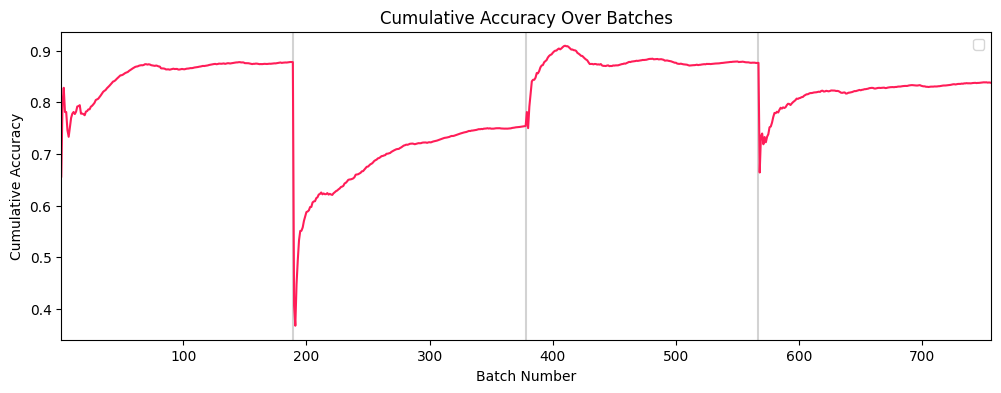

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:630: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


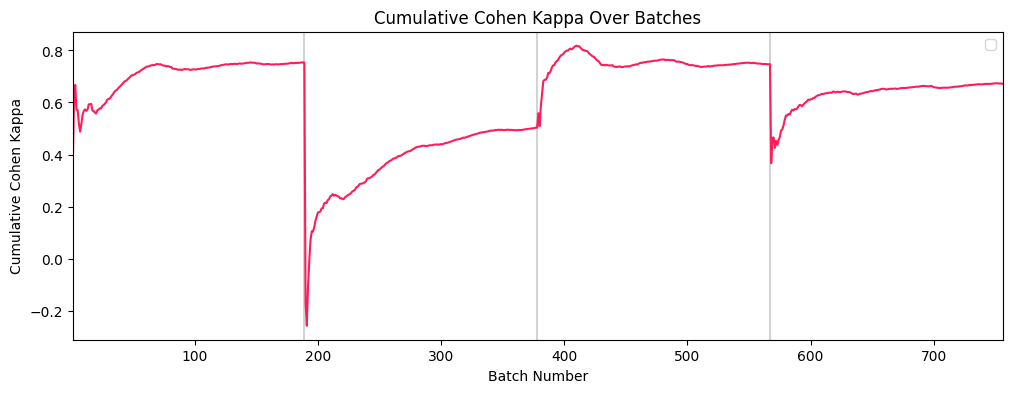

itter 1 finished
list of accuracies that used for evaluating and selecting the models =  [0.86578125]
list of kappa values that used for evaluating and selecting the models =  [0.72734231]
index of selcted mask for this task 0
All batches Accuracy=  0.8866990902051878
All batches cohen kappa=  0.7687662793372674
list of accuracies that used for evaluating and selecting the models =  [0.63828125 0.6765625 ]
list of kappa values that used for evaluating and selecting the models =  [0.26889186 0.3459926 ]
index of selcted mask for this task 1
All batches Accuracy=  0.7467304248935347
All batches cohen kappa=  0.4891466449098612
list of accuracies that used for evaluating and selecting the models =  [0.77125    0.84234375 0.77578125]
list of kappa values that used for evaluating and selecting the models =  [0.53885254 0.68390081 0.54764885]
index of selcted mask for this task 1
All batches Accuracy=  0.8572567831333074
All batches cohen kappa=  0.7104106037705032
list of accuracies that us

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:613: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


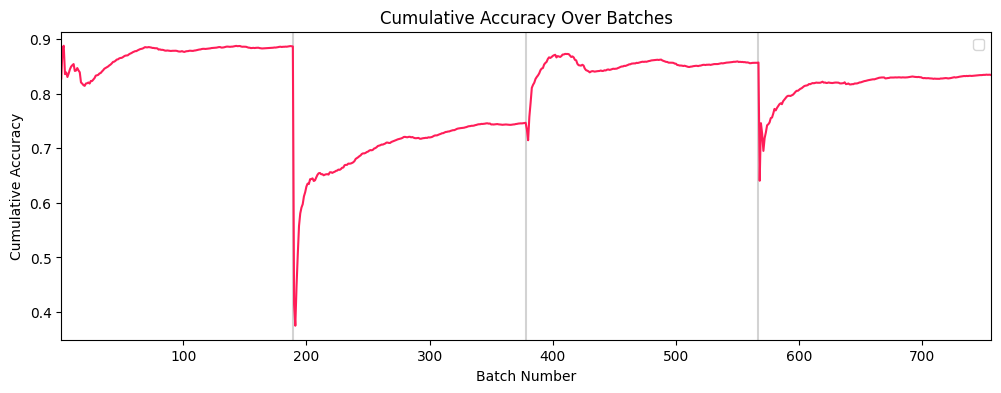

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:630: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


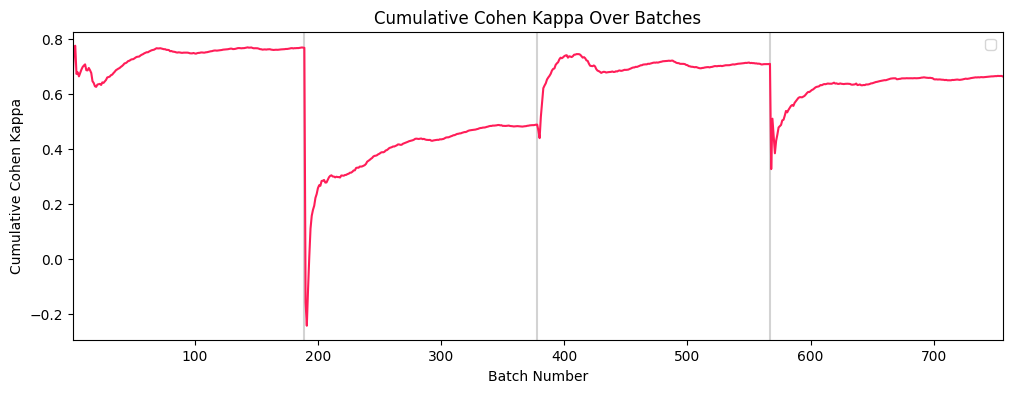

itter 2 finished
list of accuracies that used for evaluating and selecting the models =  [0.8540625]
list of kappa values that used for evaluating and selecting the models =  [0.70671209]
index of selcted mask for this task 0
All batches Accuracy=  0.8795378839205058
All batches cohen kappa=  0.756553371905019
list of accuracies that used for evaluating and selecting the models =  [0.6396875 0.6775   ]
list of kappa values that used for evaluating and selecting the models =  [0.27223641 0.34758638]
index of selcted mask for this task 1
All batches Accuracy=  0.7731027793908891
All batches cohen kappa=  0.5422795237924056
list of accuracies that used for evaluating and selecting the models =  [0.78921875 0.86765625 0.79421875]
list of kappa values that used for evaluating and selecting the models =  [0.57134888 0.73273668 0.58492589]
index of selcted mask for this task 1
All batches Accuracy=  0.8681130226480837
All batches cohen kappa=  0.7315936903001139
list of accuracies that used f

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:613: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


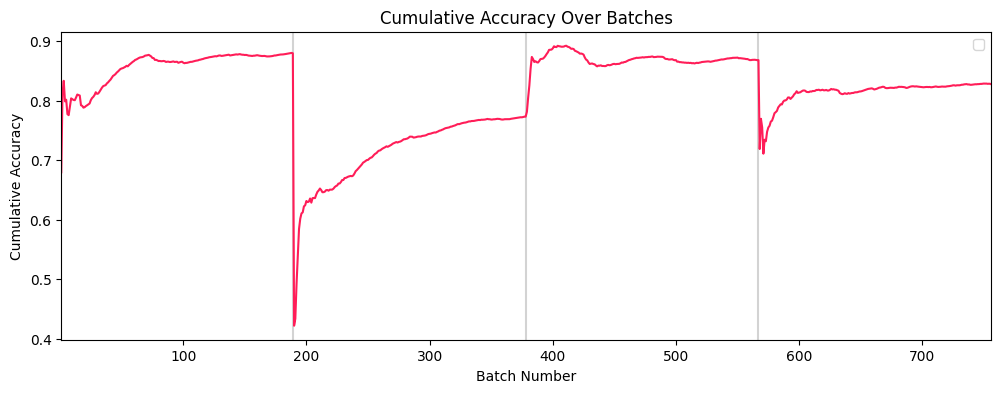

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:630: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


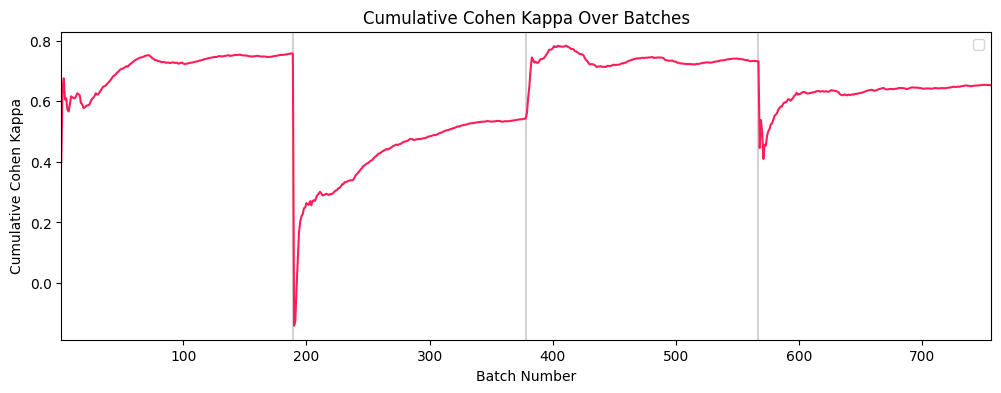

itter 3 finished
list of accuracies that used for evaluating and selecting the models =  [0.863125]
list of kappa values that used for evaluating and selecting the models =  [0.72464991]
index of selcted mask for this task 0
All batches Accuracy=  0.8833196218866951
All batches cohen kappa=  0.7637559099014474
list of accuracies that used for evaluating and selecting the models =  [0.6590625 0.6709375]
list of kappa values that used for evaluating and selecting the models =  [0.31492612 0.33594925]
index of selcted mask for this task 1
All batches Accuracy=  0.7555349883855982
All batches cohen kappa=  0.5063160763136925
list of accuracies that used for evaluating and selecting the models =  [0.741875  0.8565625 0.806875 ]
list of kappa values that used for evaluating and selecting the models =  [0.47571724 0.71079287 0.60818031]
index of selcted mask for this task 1
All batches Accuracy=  0.8633230900761388
All batches cohen kappa=  0.7226902017833063
list of accuracies that used for 

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:613: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


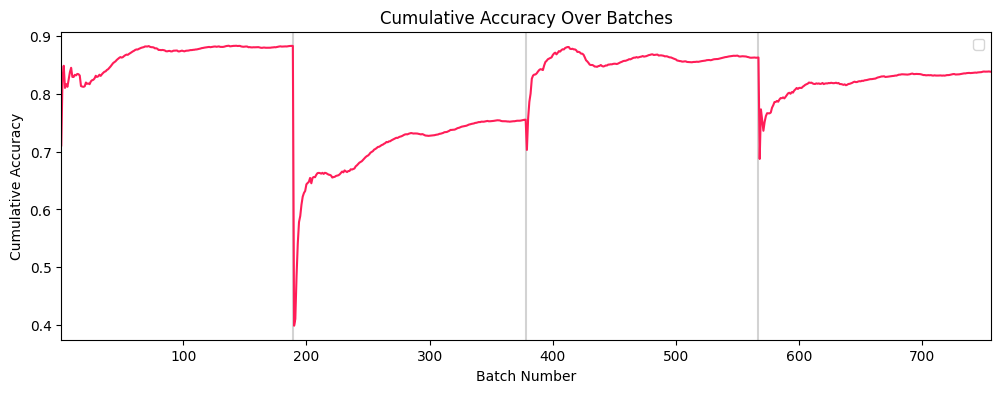

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:630: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


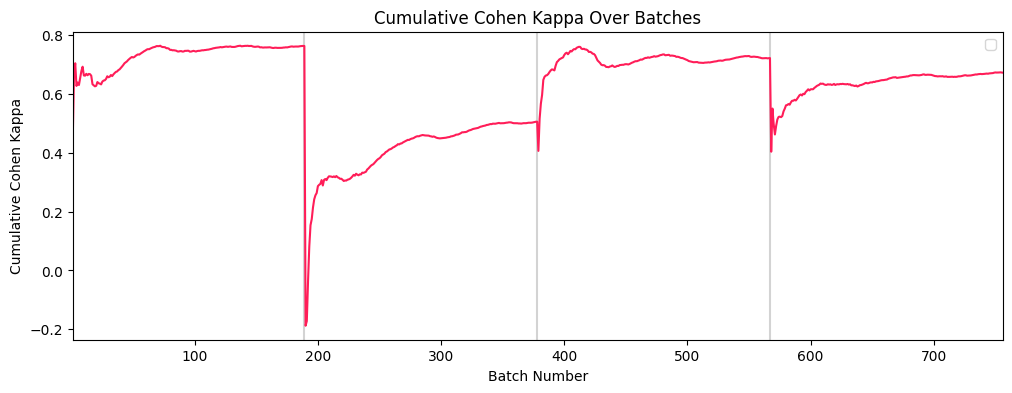

itter 4 finished
list of accuracies that used for evaluating and selecting the models =  [0.85203125]
list of kappa values that used for evaluating and selecting the models =  [0.70323087]
index of selcted mask for this task 0
All batches Accuracy=  0.8778531907342884
All batches cohen kappa=  0.7527864240307026
list of accuracies that used for evaluating and selecting the models =  [0.619375  0.6803125]
list of kappa values that used for evaluating and selecting the models =  [0.23000259 0.35573073]
index of selcted mask for this task 1
All batches Accuracy=  0.775293586269196
All batches cohen kappa=  0.5473310268784641
list of accuracies that used for evaluating and selecting the models =  [0.7046875  0.85796875 0.77890625]
list of kappa values that used for evaluating and selecting the models =  [0.40420928 0.7110904  0.55283744]
index of selcted mask for this task 1
All batches Accuracy=  0.8751915569750937
All batches cohen kappa=  0.7449816880875795
list of accuracies that used 

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:613: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


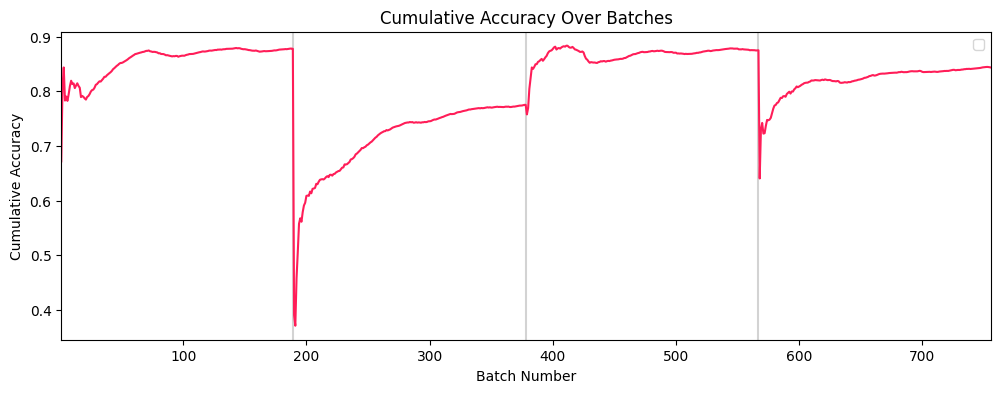

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:630: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


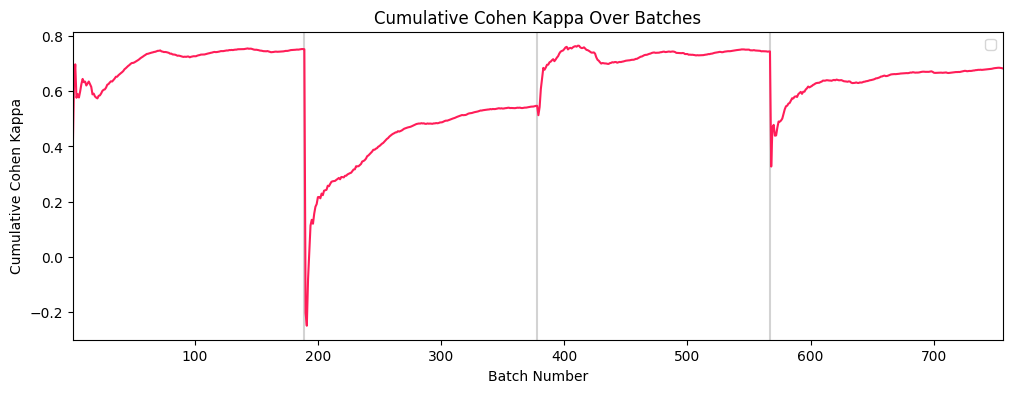

itter 5 finished
list of accuracies that used for evaluating and selecting the models =  [0.8590625]
list of kappa values that used for evaluating and selecting the models =  [0.71628754]
index of selcted mask for this task 0
All batches Accuracy=  0.8789329671570525
All batches cohen kappa=  0.7542398362248032
list of accuracies that used for evaluating and selecting the models =  [0.589375   0.66765625]
list of kappa values that used for evaluating and selecting the models =  [0.17233781 0.32955654]
index of selcted mask for this task 1
All batches Accuracy=  0.7745334075364564
All batches cohen kappa=  0.5464315656769686
list of accuracies that used for evaluating and selecting the models =  [0.74140625 0.8578125  0.7859375 ]
list of kappa values that used for evaluating and selecting the models =  [0.47962434 0.71288987 0.56755076]
index of selcted mask for this task 1
All batches Accuracy=  0.8760495305845916
All batches cohen kappa=  0.7468435750909583
list of accuracies that use

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:613: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


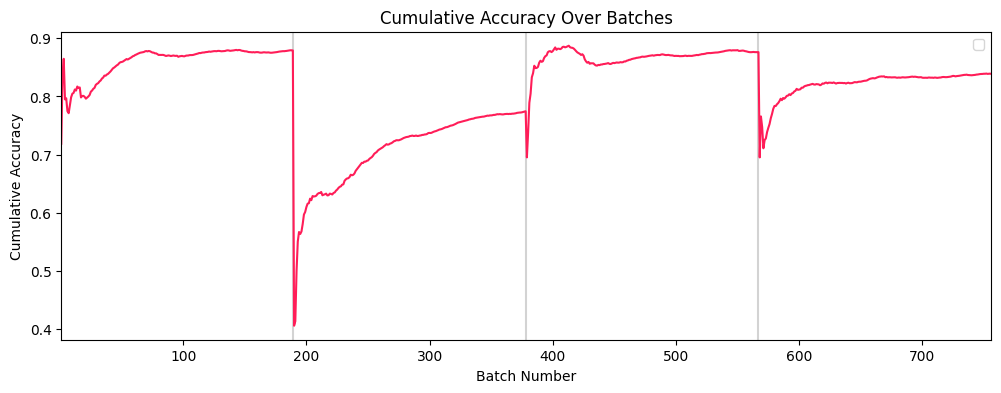

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:630: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


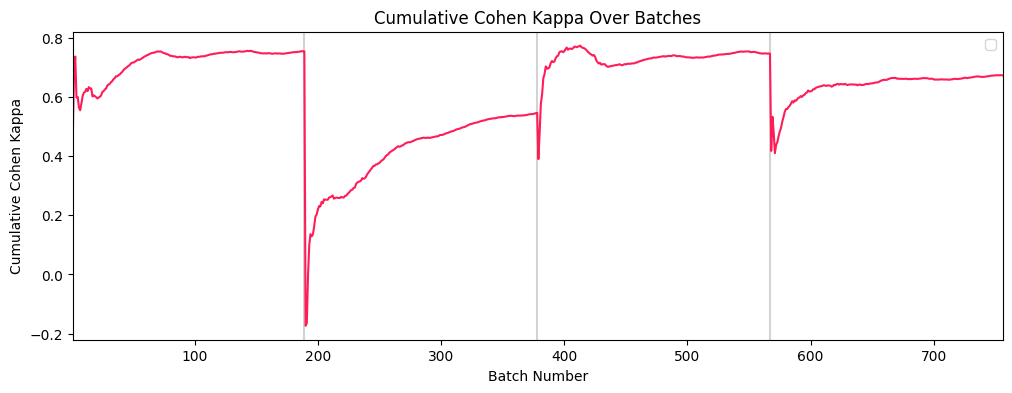

itter 6 finished
list of accuracies that used for evaluating and selecting the models =  [0.8590625]
list of kappa values that used for evaluating and selecting the models =  [0.71747742]
index of selcted mask for this task 0
All batches Accuracy=  0.8836402277713253
All batches cohen kappa=  0.7646849617440864
list of accuracies that used for evaluating and selecting the models =  [0.6028125 0.6715625]
list of kappa values that used for evaluating and selecting the models =  [0.19717407 0.33385045]
index of selcted mask for this task 1
All batches Accuracy=  0.7682301748612724
All batches cohen kappa=  0.5310965799899013
list of accuracies that used for evaluating and selecting the models =  [0.75296875 0.871875   0.790625  ]
list of kappa values that used for evaluating and selecting the models =  [0.50372736 0.73943977 0.58191774]
index of selcted mask for this task 1
All batches Accuracy=  0.8733263969544458
All batches cohen kappa=  0.7403305325479734
list of accuracies that used 

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:613: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


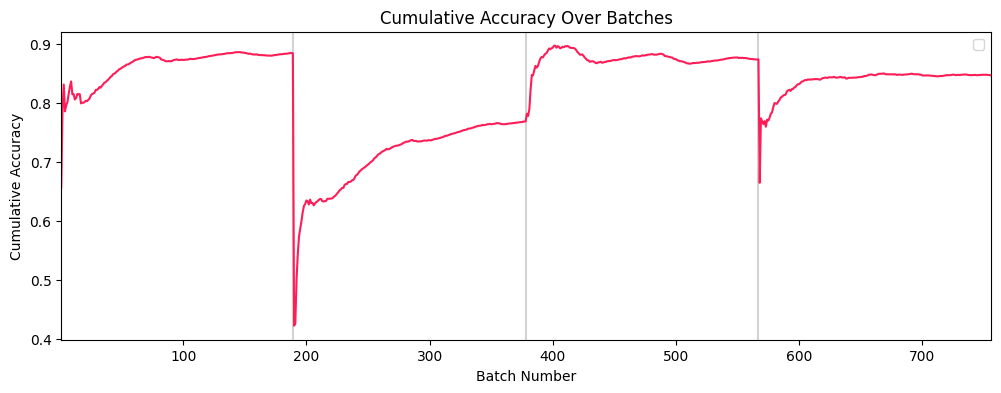

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:630: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


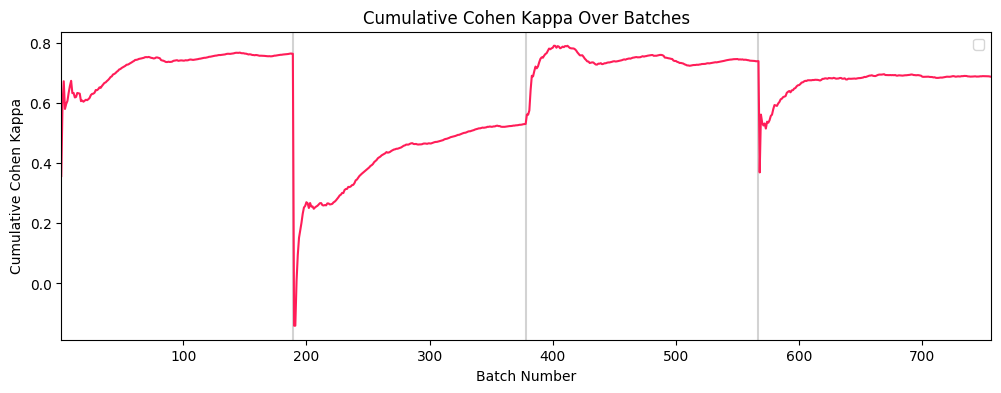

itter 7 finished
list of accuracies that used for evaluating and selecting the models =  [0.85953125]
list of kappa values that used for evaluating and selecting the models =  [0.71682699]
index of selcted mask for this task 0
All batches Accuracy=  0.8813617079623177
All batches cohen kappa=  0.7601868872920041
list of accuracies that used for evaluating and selecting the models =  [0.64359375 0.67390625]
list of kappa values that used for evaluating and selecting the models =  [0.28102761 0.3383012 ]
index of selcted mask for this task 1
All batches Accuracy=  0.763352529358627
All batches cohen kappa=  0.5221287978704644
list of accuracies that used for evaluating and selecting the models =  [0.78203125 0.87078125 0.78796875]
list of kappa values that used for evaluating and selecting the models =  [0.56165892 0.7370629  0.57242981]
index of selcted mask for this task 1
All batches Accuracy=  0.8706859352819719
All batches cohen kappa=  0.73490173255325
list of accuracies that used 

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:613: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


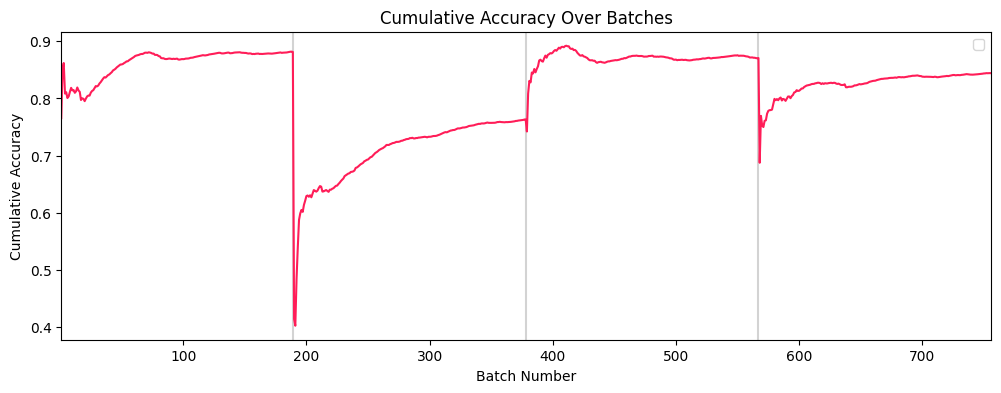

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:630: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


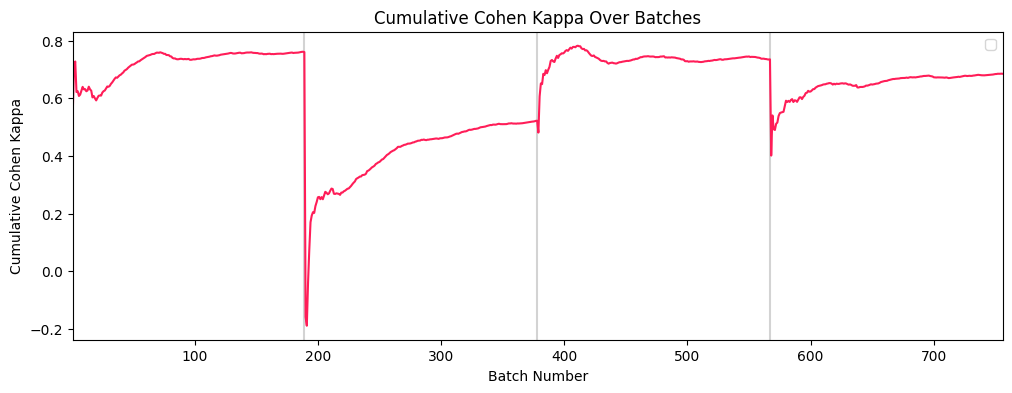

itter 8 finished
list of accuracies that used for evaluating and selecting the models =  [0.8684375]
list of kappa values that used for evaluating and selecting the models =  [0.73615541]
index of selcted mask for this task 0
All batches Accuracy=  0.8901249354755453
All batches cohen kappa=  0.777485653758049
list of accuracies that used for evaluating and selecting the models =  [0.613125   0.68515625]
list of kappa values that used for evaluating and selecting the models =  [0.22370602 0.36207296]
index of selcted mask for this task 1
All batches Accuracy=  0.7721570928506905
All batches cohen kappa=  0.5377362807276388
list of accuracies that used for evaluating and selecting the models =  [0.76015625 0.86671875 0.80109375]
list of kappa values that used for evaluating and selecting the models =  [0.51965277 0.72994384 0.60183378]
index of selcted mask for this task 1
All batches Accuracy=  0.871910891727965
All batches cohen kappa=  0.7387640924050064
list of accuracies that used 

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:613: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


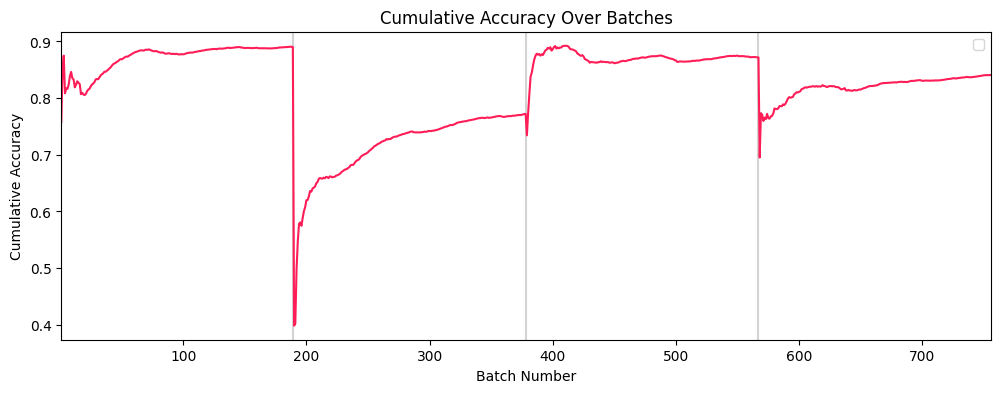

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:630: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


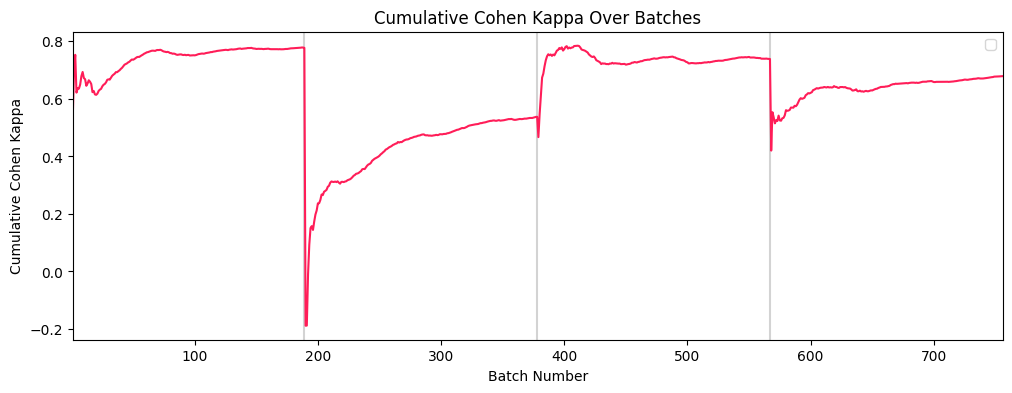

itter 9 finished
list of accuracies that used for evaluating and selecting the models =  [0.85578125]
list of kappa values that used for evaluating and selecting the models =  [0.71040402]
index of selcted mask for this task 0
All batches Accuracy=  0.8812064459930313
All batches cohen kappa=  0.7591884544602147
list of accuracies that used for evaluating and selecting the models =  [0.62578125 0.649375  ]
list of kappa values that used for evaluating and selecting the models =  [0.25042155 0.29068825]
index of selcted mask for this task 1
All batches Accuracy=  0.7360344883210737
All batches cohen kappa=  0.46824160370009915
list of accuracies that used for evaluating and selecting the models =  [0.74734375 0.83796875 0.8021875 ]
list of kappa values that used for evaluating and selecting the models =  [0.49154424 0.67203753 0.60130021]
index of selcted mask for this task 1
All batches Accuracy=  0.8528963414634148
All batches cohen kappa=  0.6998884053851562
list of accuracies that u

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:613: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


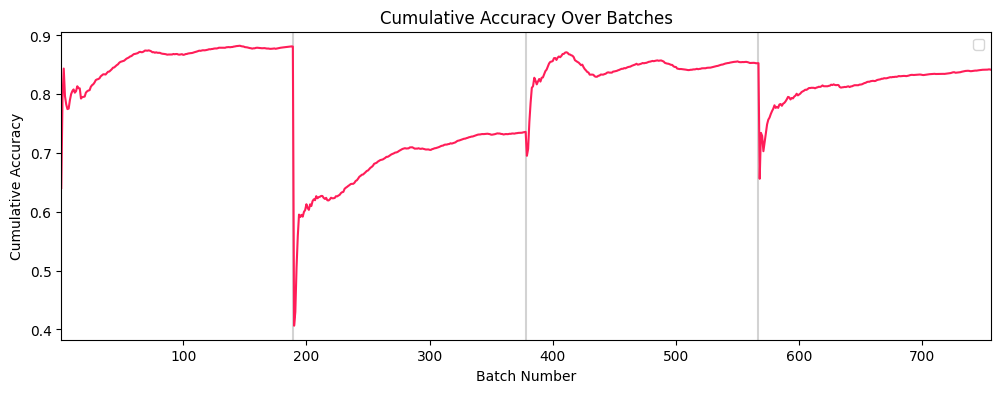

/Users/reza/Documents/GitHub/cPB/Models/cPB.py:630: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


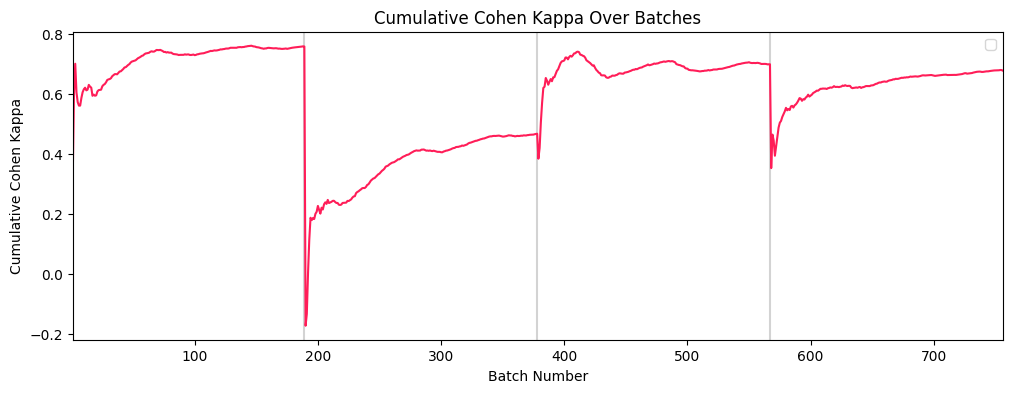

itter 10 finished


In [3]:
for iter in range(1,11):
  base_model = 'GRU'
  batch_size = 128
  hidden_size = 50
  seq_len = 11
  epoch_size=10
  lr = 0.01
  number_of_tasks=4
  mask_selection_NofBatch = 50
  input_size=4
  iteration=iter
  mask_init='uniform'
  dataset='Weather'
  dataset_name = "weather_st124_4conf"
  Pretrain_task = '1'

  df = pd.read_csv(os.path.join(f"datasets/{dataset}/", f"{dataset_name}.csv"))
  pretrain_model_addr=f'Performance/Pretrain/{base_model}/{dataset}/After/{dataset}-{base_model}-pretrain-hidden{hidden_size}-epoch10_itter{iteration}.pickle'
  mask_weights=[] #if we have initial masks then reload it here

  mask_option = 'SUM'
  model_type = 'cPB'
  batch_first = True
  low_rank = False


  model = cPB(lr = lr ,hidden_size = hidden_size, seq_len = seq_len,base_model = base_model, pretrain_model_addr = pretrain_model_addr,
            mask_weights = mask_weights, mask_init = mask_init, number_of_tasks = number_of_tasks, epoch_size = epoch_size,
            input_size = input_size, mask_option = mask_option, model_type = model_type, batch_first = batch_first, low_rank = low_rank)


  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):
          model.predict_many(x,y,mask_index,task,mask_selection=True)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column(task)
        model.predict_many(x,y,best_mask_index,task,mask_selection=False)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index,task,mask_selection=False)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


  file_path = f'Performance/Results/{model_type}/{dataset}/Periodic/pretrain_T{Pretrain_task}_{base_model}-{dataset_name}-hidden{hidden_size}-epoch10-Mask_{mask_option}-iter{iteration}.pkl'
  with open(file_path, 'wb') as file:
      pickle.dump(model.performance, file)

  file_path = f'Performance/Results/{model_type}/{dataset}/Periodic/pretrain_T{Pretrain_task}_{base_model}-{dataset_name}-hidden{hidden_size}-epoch10-Mask_{mask_option}-iter{iteration}_selectedMask.pkl'
  with open(file_path, 'wb') as file:
      pickle.dump(model.selected_mask_index, file)
      
      
  file_path=f'Performance/Final Models/{model_type}/{base_model}/{dataset}/{dataset_name}-{base_model}-pretrain-hidden{hidden_size}-epoch10-Mask_{mask_option}-itter{iteration}.pickle'
  with open(file_path, 'wb') as file:
      pickle.dump(model.all_models_weight, file)
      
  print(f'itter {iteration} finished')



In [ ]:
file_1 = f'Performance/Results/{model_type}/{dataset}/Periodic/pretrain_T{Pretrain_task}_{base_model}-{dataset_name}-hidden{hidden_size}-epoch10-Mask_{mask_option}-iter1.pkl'
with open(file_1, 'rb') as f:
    data1 = pickle.load(f)
    
data1

{'task_1': {'acc': [0.515625,
   0.6484375,
   0.703125,
   0.640625,
   0.703125,
   0.546875,
   0.65625,
   0.6953125,
   0.7578125,
   0.734375,
   0.7421875,
   0.8125,
   0.78125,
   0.6171875,
   0.78125,
   0.703125,
   0.625,
   0.7421875,
   0.8046875,
   0.8359375,
   0.84375,
   0.8046875,
   0.7109375,
   0.8671875,
   0.9140625,
   0.734375,
   0.78125,
   0.796875,
   0.8671875,
   0.7890625,
   0.828125,
   0.7109375,
   0.78125,
   0.7890625,
   0.8515625,
   0.890625,
   0.796875,
   0.765625,
   0.765625,
   0.859375,
   0.8828125,
   0.890625,
   0.8046875,
   0.84375,
   0.890625,
   0.8828125,
   0.828125,
   0.8828125,
   0.8671875,
   0.8125,
   0.8671875,
   0.8671875,
   0.828125,
   0.828125,
   0.875,
   0.875,
   0.7734375,
   0.7734375,
   0.8203125,
   0.8203125,
   0.828125,
   0.828125,
   0.8359375,
   0.8359375,
   0.828125,
   0.828125,
   0.6953125,
   0.6953125,
   0.8046875,
   0.8046875,
   0.8203125,
   0.8203125,
   0.90625,
   0.90625,
   0.87

In [ ]:
pretrain_model = GRU_Model(
                input_size=input_size,
                device=torch.device("cpu"),
                num_layers=1,
                hidden_size=50,
                output_size=4,
                batch_size=128,
            )

In [ ]:
list of accuracies that used for evaluating and selecting the models =  [0.77875]
list of kappa values that used for evaluating and selecting the models =  [0.55682867]
index of selcted mask for this task 0
All batches Accuracy=  0.8415888979773944
All batches cohen kappa=  0.6817642093079573
list of accuracies that used for evaluating and selecting the models =  [0.8825     0.78921875]
list of kappa values that used for evaluating and selecting the models =  [0.75827483 0.56541348]
index of selcted mask for this task 0
All batches Accuracy=  0.904547841686496
All batches cohen kappa=  0.8054125549771437
list of accuracies that used for evaluating and selecting the models =  [0.50046875 0.45       0.6865625 ]
list of kappa values that used for evaluating and selecting the models =  [ 0.00623575 -0.09710056  0.36576066]
index of selcted mask for this task 2
All batches Accuracy=  0.7368591054431886
All batches cohen kappa=  0.465597555778137
list of accuracies that used for evaluating and selecting the models =  [0.68984375 0.60890625 0.838125   0.77828125]
list of kappa values that used for evaluating and selecting the models =  [0.38664967 0.22596661 0.68076873 0.56018686]
index of selcted mask for this task 2
All batches Accuracy=  0.8559288555919097
All batches cohen kappa=  0.7082464730866799